# Preliminary support for predictive coding  

If inhibitory interneurons subtract a prediction of ganglion firing, we should expect higher correlations between the ganglion cells and connected inhibitory interneurons if we were able to silence inhibitory communication to the ganglion cells (but not alter the inhibitory membrane potential).  

We can essentially do this with intracellular record & playback experiments. This notebook will help provide some quantitative intuition for what direction correlations should change, as a function of stimulus statistics.

In [1]:
import numpy as np
from sklearn.decomposition import PCA
from scipy.stats import sem, pearsonr
from image_processing_functions import load_images
from lnl_model_functions import gaussian
from scipy.signal import convolve2d
from scipy.ndimage.filters import convolve1d
from scipy.interpolate import interp1d
import os

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
from matplotlib.pyplot import *

# note that nonposx(y) for log plots will no longer work with this package
import mpld3
#mpld3.enable_notebook()

from pylab import rcParams
rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# Generate stimulus  

All of our receptive fields are 1d in space, so let the stimulus be space x time.

In [3]:
stimulus_type = 'white-noise'
num_frames = 1000
num_pixels = 500

if stimulus_type == 'natural-scenes':
    im_dir = os.path.expanduser('~/Documents/Natural_Images/RawData/cd13A') # flood plain, water, horizon
    patch_size = None
    num_images = 100
    stimulus = load_images(im_dir, num_images, patch_size, square=True, normalize='divisive')

elif stimulus_type == 'white-noise':
    num_checkers = 25
    if num_pixels % num_checkers != 0:
        raise Exception('Number of pixels not divisible by number of checkers.')
    else:
        pixels_per_checker = num_pixels/num_checkers
    checkers = np.random.randn(num_checkers, num_frames)
    stimulus = np.zeros((num_pixels, num_frames))
    for idc, checker in enumerate(checkers):
        stimulus[pixels_per_checker*idc:pixels_per_checker*(idc+1)] = checker

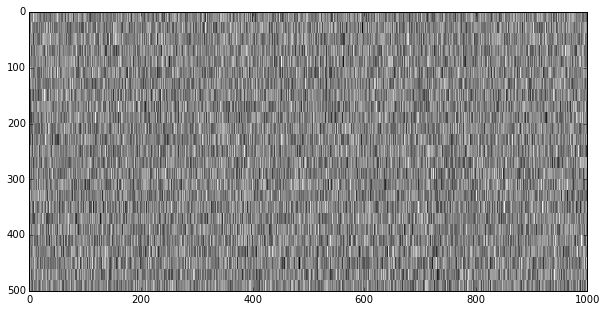

In [4]:
imshow(stimulus)

# Create model  

Model should have multiple excitatory channels where a subset of the excitation flows into an inhibitory pathway. A subset of the excitation and inhibition should then combine to give a thresholded model prediction (ganglion response).  

To make this somewhat realistic, I'll use real bipolar and amacrine cell receptive fields, and ganglion cells will be a linear combination of them.

#### Get bipolar and amacrine receptive fields

In [5]:
def get_bipolar_rfs():
    # spatialDelta = 0.022 # mm
    data_path  = os.path.expanduser('~/Documents/Stanford/00 Baccus Lab/Surround size project/david_receptive_fields')
    file_name1 = data_path + '/B1.txt'
    file_name2 = data_path + '/B2.txt'
    data_b1    = np.loadtxt(file_name1, delimiter="\t") # 50 time x 100 space
    data_b2    = np.loadtxt(file_name2, delimiter="\t") # 50 time x 100 space
    data_b     = [data_b1.T, data_b2.T] # space x time
    return data_b

def get_amacrine_rfs():
    # spatialDelta = 0.027 # mm
    data_path = os.path.expanduser('~/Documents/Stanford/00 Baccus Lab/Surround size project/david_receptive_fields')
    file_name = data_path + '/H1A2.txt'
    data_ha   = np.loadtxt(file_name, delimiter="\t")
    data_ha   = data_ha.reshape((3,50,80))
    data_a    = data_ha[1:, :, :] # first cell in this file is a horizontal cell
    rfs       = []
    for a in data_a:
        rfs.append(a.T)
    return rfs
    

#### Construct model using bipolar and amacrine receptive fields

In [110]:
def ganglion_population_response(stimulus, num_ganglion_cells=10, threshold=1, inhibitory_gain=1., 
                                 poisson_discount=3., every_n_ama=10, plot_amacrine_rfs=False):
    '''
    Stimulus should be space x time.
    Threshold should be in standard deviations.
    Returns (amacrine membrane potentials, response ganglion population x time)
    '''
    if len(stimulus.shape) != 2:
        raise Exception('Stimulus needs to be 2 dimensional.')
    
    # loading receptive fields as (space in degrees, sensitivity) tuples
    # just get one of each for now
    bipolar_rf = get_bipolar_rfs()[0]
    amacrine_rf = get_amacrine_rfs()[0]

    # how many bipolar cells and how many amacrine cells are connected to the ganglion cells,
    # and with what strength?
    bip_const = 1.
    ama_const = 78./22.
    bip_projection = [np.exp(-abs(s)/bip_const) for s in np.linspace(-22,22,bipolar_rf.shape[1])]
    ama_projection = [np.exp(-abs(s)/ama_const) for s in np.linspace(-22,22,amacrine_rf.shape[1])]
    bip_pop = convolve1d(bipolar_rf, bip_projection, axis=0)
    ama_pop = convolve1d(amacrine_rf, ama_projection, axis=0)
    
    if plot_amacrine_rfs:
        subplot(1,2,1)
        imshow(ama_pop)
        title('Population Amacrine RF', fontsize=18)
        subplot(1,2,2)
        imshow(amacrine_rf)
        title('Individual Amacrine RF', fontsize=18)
    
    # store the individual amacrine membrane potentials
    amacrines = convolve2d(stimulus, amacrine_rf, mode='same')
    
    # get the linear response of bipolar and amacrine cells
    excitation = convolve2d(stimulus, bip_pop, mode='same')
    inhibition = convolve2d(stimulus, ama_pop, mode='same')
    
    # compute ganglion response    
    ganglion_response = excitation - inhibitory_gain * inhibition
    
    # threshold response
    divide_by = ganglion_response.shape[0]/num_ganglion_cells
    ganglion_response = ganglion_response[::divide_by,:]
    thresholded = np.where(ganglion_response > threshold * np.std(ganglion_response), 
                           ganglion_response/np.max(ganglion_response), 0)
    
    # convert thresholded response to poisson spiking
    spiking = np.random.poisson(thresholded/poisson_discount)
    return ((amacrines/np.max(abs(amacrines)))[::every_n_ama], np.where(spiking > 1, 1, 0))

In [81]:
inhibition, ganglions = ganglion_population_response(stimulus, threshold=.2, poisson_discount=1.)

In [82]:
inhibition.shape

(50, 1000)

In [83]:
ganglions.shape

(10, 1000)

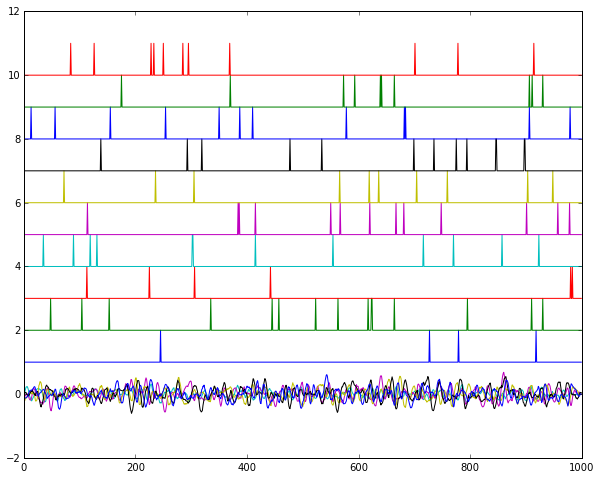

In [84]:
# if we limit ourselves to every 10th, the inhibitory cells should line up with the ganglion cells
p = plot(ganglions.T + np.arange(10) + 1)
p = plot(inhibition[::10,:].T)

In [85]:
control_corrs = {}
for idg,g in enumerate(ganglions):
    for i in inhibition:
        if idg in control_corrs.keys():
            control_corrs[idg].append(pearsonr(g,i)[0])
        else:
            control_corrs[idg] = [pearsonr(g,i)[0]]

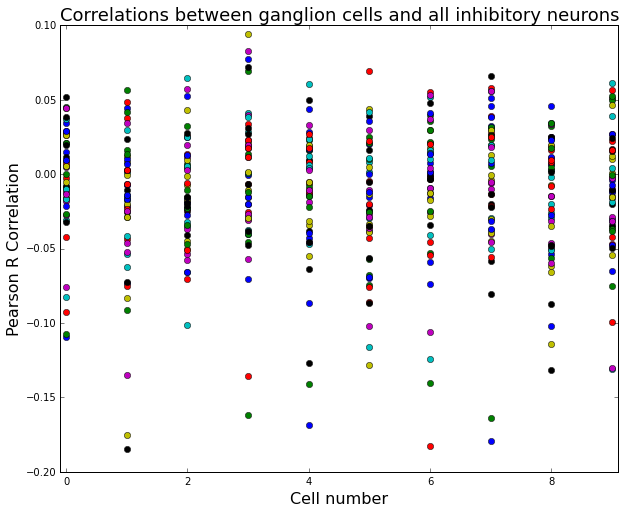

In [91]:
p = plot(control_corrs.values(), 'o')
xlim([-0.1, 9.1])
title('Correlations between ganglion cells and all inhibitory neurons', fontsize=18)
xlabel('Cell number', fontsize=16)
ylabel('Pearson R Correlation', fontsize=16)

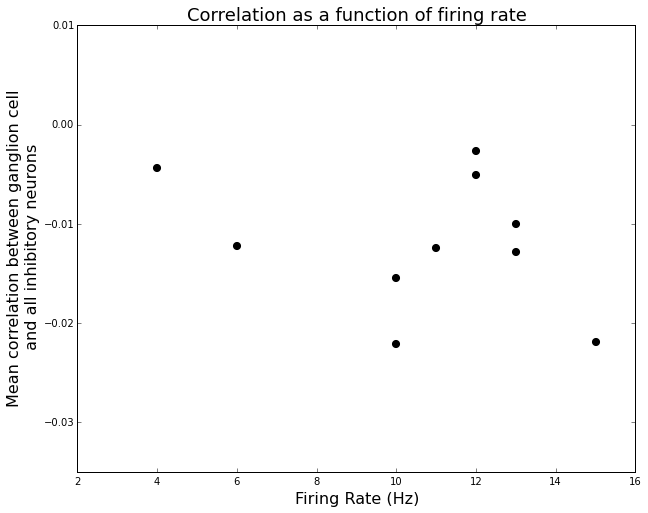

In [87]:
scatter(np.sum(ganglions, axis=1), np.mean(control_corrs.values(), axis=1), s=50, c='k')
title('Correlation as a function of firing rate', fontsize=18)
xlabel('Firing Rate (Hz)', fontsize=16)
ylabel('Mean correlation between ganglion cell \n and all inhibitory neurons', fontsize=16)

In [88]:
pearsonr(np.sum(ganglions, axis=1), abs(np.nanmean(control_corrs.values(), axis=1)))

(0.29115146126428892, 0.41440460350900038)

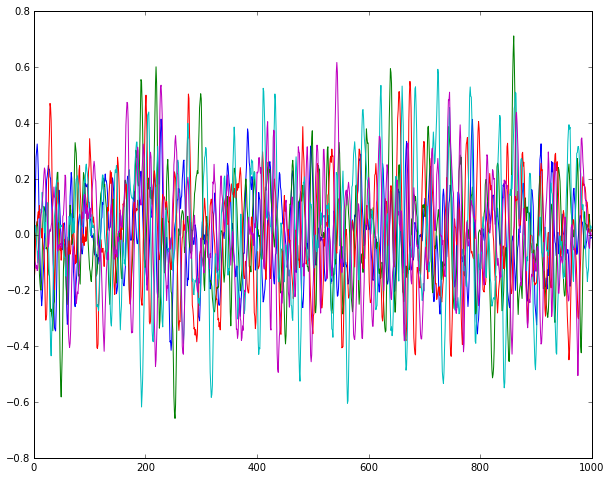

In [41]:
p = plot(inhibition[::10,:].T)

# Compute correlations between ganglion pairs

In [93]:
ganglion_corrs = np.zeros((len(ganglions), len(ganglions)))
for idg,g1 in enumerate(ganglions):
    for jdg,g2 in enumerate(ganglions):
        ganglion_corrs[idg,jdg] = pearsonr(g1,g2)[0]

<matplotlib.colorbar.Colorbar instance at 0x11993f3b0>

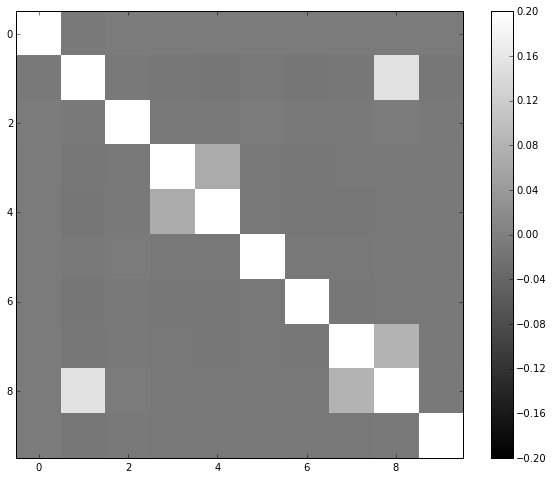

In [104]:
imgplot = imshow(ganglion_corrs)
imgplot.set_clim(-0.2,0.2)
colorbar()

In [109]:
np.diag(ganglion_corrs, k=-1)

array([-0.00782038, -0.0095876 , -0.00856238,  0.06842946, -0.01153441,
       -0.01153441, -0.0126481 ,  0.08122617, -0.01059938])

In [114]:
inhibition, ganglions = ganglion_population_response(stimulus, threshold=.2, poisson_discount=1.,
                                                    num_ganglion_cells=500, every_n_ama=1)

In [115]:
inhibition.shape

(500, 1000)

In [116]:
ganglions.shape

(500, 1000)

In [117]:
ganglion_corrs = np.zeros((len(ganglions), len(ganglions)))
for idg,g1 in enumerate(ganglions):
    for jdg,g2 in enumerate(ganglions):
        ganglion_corrs[idg,jdg] = pearsonr(g1,g2)[0]

<matplotlib.colorbar.Colorbar instance at 0x11c671098>

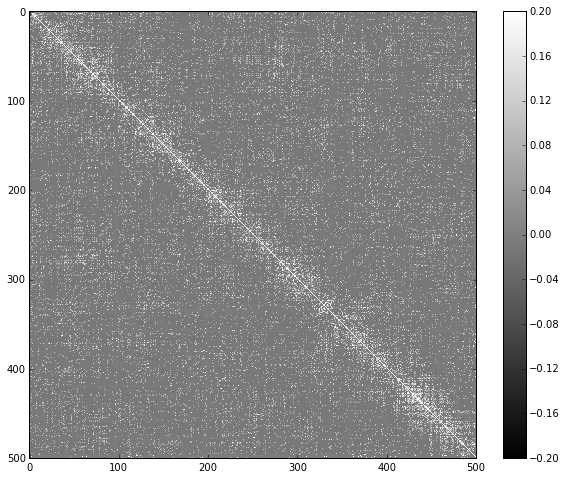

In [118]:
imgplot = imshow(ganglion_corrs)
imgplot.set_clim(-0.2,0.2)
colorbar()

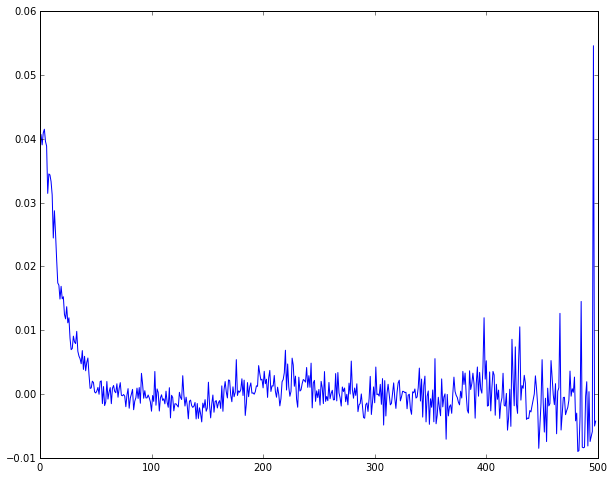

In [149]:
corr_fn_dist = [np.mean(np.diag(ganglion_corrs, k=d)) for d in -np.arange(1,len(ganglions)-1)]
plot(np.arange(1,len(ganglions)-1), corr_fn_dist)

In [167]:
normalized_response = ganglions - np.mean(ganglions)
ganglion_corrs_straight = normalized_response.dot(normalized_response.T)/(4*len(ganglions) * np.var(ganglions))

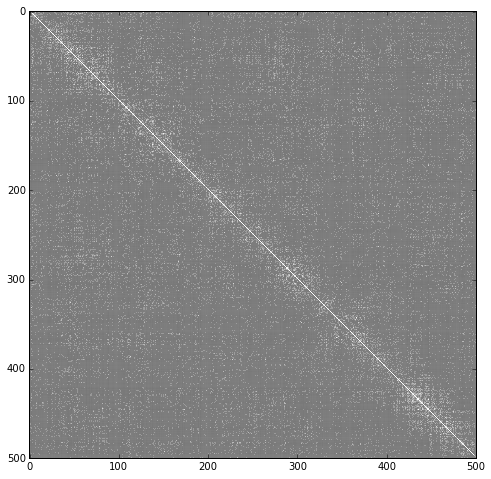

In [168]:
imgplot = imshow(ganglion_corrs_straight)
imgplot.set_clim([-0.2, 0.2])

In [169]:
(np.min(ganglion_corrs_straight), np.max(ganglion_corrs_straight))

(-0.015470584668862834, 1.0061949977179339)

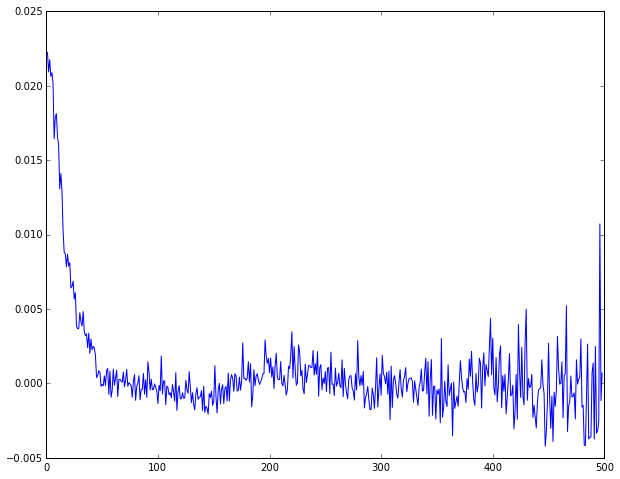

In [170]:
corr_fn_dist = [np.mean(np.diag(ganglion_corrs_straight, k=d)) for d in -np.arange(1,len(ganglions)-1)]
plot(np.arange(1,len(ganglions)-1), corr_fn_dist)

# Compute correlations across space and time between ganglion-amacrine pairs